# Firm Problem with Non-Convex Adjustment Costs
### by [Jason DeBacker](http://jasondebacker.com), December 2017
This Jupyter notebook will use discerete choice dynanic programming to solve the firm dynamics model with non-convex capital adjustment costs.


## The firm's problem

Consider our stochastic firm problem represented by the following Bellman equation:

$$ V(z,k) = \max_{k'} \pi(z,k) - (k'-(1-\delta)k) - c(k,k') + \beta E_{z'|z}V(z',k') $$

Suppose that the cost function, $c(k,k')$ is not convex.  In particular, assume that there is a fixed cost to investing such that:

$$ c(k,k') = 1_{I\neq 0} [ Fk], $$

where $F$ is the fixed cost to adjusting the firms captial stock.  The total fixed costs incurred are proportional to the firm's total capital stock.  So if $k'=(1-\delta)k$, then $c(k,k')=0$ and $c(k,k')=F\times k$ otherwise.


## Solving this probem

To solve this problem we need to consider that the firm faces a discontinuity at $I=0$.  Thus, there is not a first order condition that we could use to analyze the firm's problem (this also rules out policy function iteration as a solution method).  To deal with this, we'll set up the firm's problem as a discere choice problem.  The firms will consider - do I invest or not?  And then, if it investes, how much?

To help us think about the solution, let's rewrite the Bellman equation in a way that captures the discontinuity:

$$V(z,k) = max\{V^{i}(z,k),V^{a}(z,k)\}, $$

where the superscript $i$ stands for "inactive" (i.e., $I=0$) and $a$ stands for active.  These values are then given by:

$$ V^{i}(z,k) = \pi(z,k) + \beta E_{z'|z}V(z',(1-\delta)k) $$

and 

$$ V^{a}(z,k) = \max_{k'} \pi(z,k) - (k'-(1-\delta)k) - Fk + \beta E_{z'|z}V(z',k') $$

We'll need to solve for the value functions: $V^{i}(z,k)$, $V^{a}(z,k)$ and $V(z,k)$, as well as the policy function $k'=h(z,k)$.  

Thinking about the nature of the problem - costs only incurred if an investmet is made, we can see that there is going to be some threshold rule in this problem - if $k$ is far from some target amount, make an invetsment - and don't otherwise.

To solve for these unknown functions, we'll use value function iteration.

### Setting up the problem

First, we need to define paramters and set up our gride space.

In [29]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import numba
import ar1_approx as ar1
% matplotlib inline

# Define parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
F = 0.02
w = 0.7
r = 0.04
betafirm = (1 / (1 + r))
sigma_eps = 0.213
mu = 0
rho = 0.7605
sizez = 9

# Grid for z and transition matrix
# We will use the Rouwenhorst (1995) method to approximate a continuous
# distribution of shocks to the AR1 process with a Markov process.
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
num_sigma = 3
step = (num_sigma * sigma_z) / (sizez / 2)
Pi, z = ar1.rouwen(rho, mu, step, sizez)
Pi = np.transpose(Pi)  # make so rows are where start, columns where go
z = np.exp(z)  # because the AR(1) process was for the log of productivity

# Grid for k
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z[(sizez - 1) // 2] ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 12 #kstar * 500
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.empty(int(numb * dens))
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

Next, we'll define some objects that will be useful in our VFI solution.  For example, we can compute the per period flows to the firm, calling them $e(z,k,k')$:

In [30]:
# initialize array of per period flows - separately for active and inactive
e_a = np.empty((sizez, sizek, sizek))
e_i = np.empty((sizez, sizek))
for i in range(sizez):  # loop over z
    for j in range(sizek):  # loop over k
        op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
                ((z[i] * kvec[j] ** alpha_k) ** (1 / (1 - alpha_l))))
        e_i[i, j] = op
        for m in range(sizek):  # loop over k'
            e_a[i, j, m] = (op - kvec[m] + ((1 - delta) * kvec[j]) -
                            (F * kvec[j]))

Before getting to our Bellman operator, let's define a function that will be useful in that operator.  This function simply creates the value of the first at each combination of state and choice of control variable:

In [31]:
@numba.jit
def create_Vmat(EV, e, betafirm, Pi, sizez, sizek, Vmat):
    '''
    This function loops over the state and control variables, operating on the
    value function to update with the last iteration's value function
    '''
    for i in range(sizez):  # loop over z
        for j in range(sizek):  # loop over k
            for m in range(sizek):  # loop over k'
                Vmat[i, j, m] = e[i, j, m] + betafirm * EV[i, m]

    return Vmat

Finally, we'll set up our VFI loop:

In [32]:
# VFI 
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizez, sizek))  # initial guess at value function
EV_i = np.empty((sizez, sizek))  # initialize EV_i
Vmat = np.empty((sizez, sizek, sizek))  # initialize Vmat matrix
Vstore = np.empty((sizez, sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    EV = np.dot(Pi, V)  # expected VF if change capital (expectation over z')
    EV_i[:, dens:] = EV[:, :sizek - dens]
    EV_i[:, :dens] = np.tile(np.reshape(EV[:, 0], (sizez, 1)), (1, dens))
    Vmat = create_Vmat(EV, e_a, betafirm, Pi, sizez, sizek, Vmat)
    V_i = e_i + betafirm * EV_i
    V_a = Vmat.max(axis=2)  # apply max operator to Vmat (to get V(k))
    PF_continuous = np.argmax(Vmat, axis=2)
    V = np.maximum(V_a, V_i)
    Vstore[:, :, VFiter] = V.reshape(sizez, sizek)  # store value function at
    # each iteration for graphing later
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF = V  # solution to the functional equation


# creating discrete choice policy function
PF_discrete = np.empty((sizez, sizek))
for i in range(sizez):
    for j in range(sizek):
        if V_i[i, j] >= V_a[i, j]:
            PF_discrete[i, j] = 0  # policy function = 0 if no change
            PF_continuous[i, j] = np.max(j-dens, 0)
        elif V_a[i, j] > V_i[i, j]:
            PF_discrete[i, j] = 1  # policy function = 1 if change
            PF_continuous[i, j] = PF_continuous[i, j]

Value function converged after this many iterations: 366
VFI took  1.1520770000000002  seconds to solve


## Decision rules

Let's plot the firm's optimal investment rate to see if there is the "threshold" rule we'd expect.

In [33]:
# Determine policy functions for k' and I
optK = kvec[PF_continuous]
optI = optK - (1 - delta) * kvec

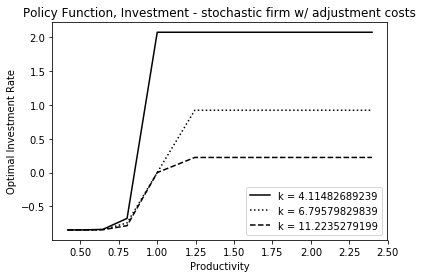

In [34]:
# Plot investment rule as a function of productivity
fig, ax = plt.subplots()
ind = np.argmin(np.absolute(kvec - kstar))  # find where kstar is in grid
ax.plot(z, optI[:, ind - dens * 3] / kvec[ind - dens * 3], 'k', label='k = ' +
        str(kvec[ind - dens * 3]))
ax.plot(z, optI[:, ind] / kvec[ind], 'k:', label='k = ' + str(kvec[ind]))
ax.plot(z, optI[:, ind + dens * 3] / kvec[ind + dens * 3], 'k--', label='k = '
        + str(kvec[ind + dens * 3]))
plt.xlabel('Productivity')
plt.ylabel('Optimal Investment Rate')
plt.title('Policy Function, Investment - stochastic firm w/ adjustment ' +
          'costs')
plt.legend()